Find the latest version here: https://colab.research.google.com/drive/1cnSjyYMeAftgX_BOjvuDBcjqZfMLWi3s?usp=sharing

In [2]:
pip install gekko

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 12.2 MB/s eta 0:00:00


In [3]:
import numpy as np
from gekko import GEKKO
import matplotlib.pyplot as plt

In [4]:
def tot_links_opt(utxos, x):
    sum = 0
    for i in range(len(utxos)):
        if x[i] > 0:
            sum += utxos[i]['l']
    return sum

def tot_links(utxos):
    sum = 0
    for u in utxos:
        sum += u['l']
    return sum

def frac_old_txns(utxos, threshold):
    sum = 0
    for u in utxos:
        if u['a'] > threshold:
            sum += 1
    return sum/len(utxos)


matchRange=0
def BnBRecursion(d,currentSelection, rounds, utxos,t,j):
    rounds = rounds - 1
    utxosSorted = [u for u in utxos if u not in currentSelection]
    utxosSorted = sorted(utxosSorted, key=lambda x: x[f'v_{j}'], reverse=False)
    TrFee = len(currentSelection) * 0.5
    if sum_j(currentSelection, j) > t[j] + int(j==0)*TrFee:
        return currentSelection
    elif sum_j(currentSelection, j) > t[j] + int(j==0)*TrFee + matchRange:
        return []
    elif rounds <= 0:
        return []
    elif d >= len(utxosSorted):
        return []

    randInt = np.random.randint(0, 2)
    randBool = bool(randInt)
    if randBool:
        currentSelection.append(utxosSorted[d])
        withThis = BnBRecursion(d+1, currentSelection, rounds, utxos,t,j)
        if len(withThis)>0:
            return withThis
        else:
            currentSelection.pop()
            withoutThis = BnBRecursion(d+1, currentSelection, rounds, utxos,t,j)
            if len(withoutThis) > 0:
                return withoutThis


    else:
        withoutThis = BnBRecursion(d + 1, currentSelection, rounds, utxos,t,j)
        if len(withoutThis) > 0:
            return withoutThis
        else:
            currentSelection.append(utxosSorted[d])
            withThis = BnBRecursion(d+1, currentSelection, rounds, utxos,t,j)
            if len(withThis) > 0:
                return withThis

    return currentSelection


def hvf(utxos, T, lam1=0.5,  lam2=0.5):
    sorted_list = utxos.copy()
    j_max = 3
    selected = []

    for j in range(j_max):
        selected_index = []
        sorted_list = sorted(sorted_list, key=lambda x: x[f'v_{j}'], reverse=True)
        sum = 0
        TrFee = len(selected) * 0.5
        if j>0:
            sum = sum_j(selected,j)
        if sum < T[j] + int(j==0)*TrFee:
            for l in range(len(sorted_list)):
                if sorted_list[l][f'v_{j}'] > 0:
                    selected.append(sorted_list[l])
                    selected_index.append(l)
                    TrFee = len(selected)*0.5
                    sum += selected[-1][f'v_{j}']
                    if sum >= T[j] + int(j==0)*TrFee:
                        break
            sorted_list = [sorted_list[l] for l in range(len(sorted_list)) if l not in selected_index]
    cu = {
        'a': 1,  # age
        'l': tot_links(selected), #len(selected),  # links
        's': 30  # size
    }
    for j in range(j_max):
        cu[f'v_{j}'] = sum_j(selected,j) - T[j] - int(j==0) * TrFee



    for u in sorted_list:
        u['a'] = u['a'] + 1
    sorted_list.append(cu)

    return sorted_list, len(selected)


def lvf(utxos, T, lam1=0.5,  lam2=0.5):
    sorted_list = utxos.copy()
    j_max = 3
    selected = []

    for j in range(j_max):
        selected_index = []
        sorted_list = sorted(sorted_list, key=lambda x: x[f'v_{j}'])
        sum = 0
        TrFee = len(selected) * 0.5
        if j>0:
            sum = sum_j(selected,j)
        if sum < T[j] + int(j==0)*TrFee:
            for l in range(len(sorted_list)):
                if sorted_list[l][f'v_{j}'] > 0:
                    selected.append(sorted_list[l])
                    selected_index.append(l)
                    TrFee = len(selected)*0.5
                    sum += selected[-1][f'v_{j}']
                    if sum >= T[j] + int(j==0)*TrFee:
                        break
            sorted_list = [sorted_list[l] for l in range(len(sorted_list)) if l not in selected_index]
    cu = {
        'a': 1,  # age
        'l': tot_links(selected), #len(selected),  # links
        's': 30  # size
    }
    for j in range(j_max):
        cu[f'v_{j}'] = sum_j(selected,j) - T[j] - int(j==0) * TrFee

    #

    for u in sorted_list:
        u['a'] = u['a'] + 1
    sorted_list.append(cu)

    return sorted_list, len(selected)


def greedy(utxos, T):
    sorted_list = utxos.copy()
    selected = []
    for j in range(j_max):
        selected_index = []
        TrFee = len(selected) * 0.5
        sorted_list = sorted(sorted_list, key=lambda x: x[f'v_{j}'])

        for i in range(len(sorted_list) - 1, 0, -1):
            if sum_j(selected,j) < T[j] + int(j == 0) * TrFee and sorted_list[i][f'v_{j}'] < T[j] + int(j == 0) * TrFee:
                selected.append(sorted_list[i])
                selected_index.append(i)
                TrFee = len(selected) * 0.5
        sorted_list = [sorted_list[l] for l in range(len(sorted_list)) if l not in selected_index]

    remaining_index = []
    for j in range(j_max):
        TrFee = len(selected) * 0.5
        if sum_j(selected,j) < T[j] + int(j == 0) * TrFee:
            remaining_index.append(j)

    if len(remaining_index)>0:
        for j in remaining_index:
            sorted_list = sorted(sorted_list, key=lambda x: x[f'v_{j}'])
            while sum_j(selected,j) < T[j] + int(j == 0) * TrFee:
                selected.append(sorted_list[0])
                del sorted_list[0]
    cu = {
        'a': 1,  # age
        'l': tot_links(selected),  # len(selected),  # links
        's': 30  # size
    }
    for j in range(j_max):
        cu[f'v_{j}'] = sum_j(selected, j) - T[j] - int(j == 0) * TrFee

    for u in sorted_list:
        u['a'] = u['a'] + 1
    sorted_list.append(cu)

    return sorted_list, len(selected)

def rndDrw(utxos,T):
    selected = []
    for j in range(j_max):
        TrFee = len(selected) * 0.5
        while T[j] - sum_j(selected, j) - int(j==0)*TrFee> 0:
            idx = np.random.randint(0, len(utxos))
            selected.append(utxos[idx])
            del utxos[idx]
            TrFee = len(selected) * 0.5

    cu = {
        'a': 1,  # age
        'l': tot_links(selected), #len(selected),  # links
        's': 30  # size
    }
    for j in range(j_max):
        cu[f'v_{j}'] = sum_j(selected,j) - T[j] - int(j==0) * TrFee

    for u in utxos:
        u['a'] = u['a'] + 1
    utxos.append(cu)

    return utxos, len(selected)


def priority(u,j, mean):
  return (u[f'v_{j}'] * u['a']) / ((u['l'] + 1) * np.sqrt(((u[f'v_{j}'] - mean)**2 + 1)))

def calc_mean(S,j):
  s = 0
  for u in S:
    s = s + u[f'v_{j}']
  return s / len(S)

def sum_j(S, j):
  s = 0
  for u in S:
    s += u[f'v_{j}']
  return s


def sum2_j(S, x, j):
  s = 0
  for u in S:
    s += u[f'v_{j}'] * x[j]
  return s

def obj_fct2(x,utxos,j_max,mean, input_tot, lam1, lam2, TrFee, m):
  obj = 0
  for i in range(len(utxos)):
      sum_priorities = 0
      if x[i].Value != 0:
        for j in range(j_max):
          sum_priorities += priority(utxos[i], j, mean[j])
        obj += x[i] * sum_priorities
  obj2 = 0
  for j in range(j_max):
    obj2 += (int(j==0) * TrFee + T[j]) / (1 + m.abs2(input_tot[j] - int(j==0) * TrFee - T[j]))
  return 0.25 * obj + 0.25 * 1/(2+sum([x[i] for i in range(len(x))])) + 0.25 * obj2

def optimize(utxos, T, lam1=0.5,  lam2=0.5):
    m=GEKKO(remote=False)
    j_max = 3  # number of assets that exist
    n = len(utxos)
    x = [m.Var(lb=0, ub=1, integer=True) for j in range(n)]

    minADA = 1
    minUT1 = 0
    minUT2 = 0

    TrFee = sum([x[i] for i in range(len(x))]) * 0.5

    mean = []
    for j in range(j_max):
        mean.append(calc_mean(utxos, j))


    #Constraint1
    input_tot = []
    input_tot_values = []
    for asset_no in range(j_max):
        s = 0
        for utxo_no in range(len(utxos)):
            s += utxos[utxo_no][f'v_{asset_no}'] * x[utxo_no]
        input_tot.append(s)
        input_tot_values.append(m.Intermediate(s).VALUE)  # m.Intermediate gives an expression evalutated afer m.solve(). Otherwise it still contains x_i variables
        m.Equation(s >= T[asset_no] + int(asset_no == 0) * (TrFee + minADA) + int(asset_no == 1) * minUT1 + int(asset_no == 2) * minUT2)


    change_utxo = []

    cu = {
        'a': 0,  # age
        'l': 0,  # links
        's': 30  # size
    }

    # same change UTXO but with m.Intermediate(), s.t. we see evaluated expression
    cuu = {
        'a': 0,  # age
        'l': 0,  # links
        's': 30  # size
    }

    for j in range(j_max):
        cuu[f'v_{j}'] = m.Intermediate(input_tot[j] - T[j] - int(j == 0) * TrFee).VALUE
        cu[f'v_{j}'] = (input_tot[j] - T[j] - int(j == 0) * TrFee)

    change_utxo.append(cu)

    o = obj_fct2(x,utxos,j_max,mean, input_tot, lam1, lam2, TrFee, m)
    m.Maximize(o)
    m.options.SOLVER = 1
    m.solve()
    print(x)
    for j in range(j_max):
        cuu[f'v_{j}'][0] = cuu[f'v_{j}'][0]
        cuu[f'v_{j}'] = cuu[f'v_{j}'][0]
    change_utxo_values = []

    change_utxo_values.append(cuu)


    return x, change_utxo_values




if __name__ == "__main__":
    np.random.seed(2)
    # utxo structure:
    u1 = {
        'v_0': 80000,  # value ADA
        'v_1': 0,  # value UT1
        'v_2': 0,  # value UT2
        'a': 1,  # age
        'l': 0,  # links
        's': 50  # size
    }

    u2 = {
        'v_0': 10000,  # value ADA
        'v_1': 100000,  # value UT1
        'v_2': 0,  # value UT2
        'a': 1,  # age
        'l': 0,  # links
        's': 50  # size
    }

    u3 = {
        'v_0': 10000,  # value ADA
        'v_1': 0,  # value UT1
        'v_2': 100000,  # value UT2
        'a': 1,  # age
        'l': 0,  # links
        's': 60  # size
    }

    j_max = 3


    utxo = [u1, u2, u3]
    utxo2 = [u1, u2, u3]
    utxo3 = [u1, u2, u3]
    utxo4 = [u1, u2, u3]
    utxo5 = [u1, u2, u3]
    utxo6 = [u1, u2, u3]



    iterations = 1000

    poolsize = [len(utxo)]
    poolsize2 = [len(utxo2)]
    poolsize3 = [len(utxo3)]
    poolsize4 = [len(utxo4)]
    poolsize5 =  [len(utxo5)]
    poolsize6 = [len(utxo6)]
    frac_Old_Txns = [0]
    frac_Old_Txns2 = [0]
    frac_Old_Txns3 = [0]
    frac_Old_Txns4 = [0]
    frac_Old_Txns5 = [0]
    frac_Old_Txns6 = [0]
    numberOfInputs = []
    numberOfInputs2 = []
    numberOfInputs3 = []
    numberOfInputs4 = []
    numberOfInputs5 = []
    numberOfInputs6 = []
    balance = [{
        'v_0': 100000,  # value ADA
        'v_1': 100000,  # value UT1
        'v_2': 100000
    }]
    balance2 = [{
        'v_0': 100000,  # value ADA
        'v_1': 100000,  # value UT1
        'v_2': 100000
    }]
    balance3 = [{
        'v_0': 100000,  # value ADA
        'v_1': 100000,  # value UT1
        'v_2': 100000
    }]
    balance4 = [{
        'v_0': 100000,  # value ADA
        'v_1': 100000,  # value UT1
        'v_2': 100000
    }]
    balance5 = [{
        'v_0': 100000,  # value ADA
        'v_1': 100000,  # value UT1
        'v_2': 100000
    }]
    balance6 = [{
        'v_0': 100000,  # value ADA
        'v_1': 100000,  # value UT1
        'v_2': 100000
    }]
    targets = []
    deposits = []
    counter = 0
    for it in range(iterations):
        rounds = 1000
        d = 0
        currentSelection = []

        T = abs(np.random.poisson(3000, 3)).tolist()
        targets.append(T)

        utxo2, no_of_inputs = lvf(utxo2, T)
        numberOfInputs2.append(no_of_inputs)

        utxo3, no_of_inputs = hvf(utxo3, T)
        numberOfInputs3.append(no_of_inputs)

        for j in range(j_max):
            currentSelection = BnBRecursion(d, currentSelection, rounds, utxo4, T, j)
            if len(currentSelection) == 0:
                TrFee = 0
                while T[j]+ int(j==0)*TrFee - sum_j(currentSelection,j) > 0:
                    rand = np.random.choice(utxo4)
                    currentSelection.append(rand)
                    TrFee = len(currentSelection)*0.5
                    utxo4.remove(rand)

        utxo4 = [u for u in utxo4 if u not in currentSelection]
        for u in utxo4:
            u['a'] = u['a'] + 1

        change = {
            'a': 1,  # age
            'l': tot_links(currentSelection), #len(currentSelection),  # links
            's': 60  # size
        }
        TrFee = len(currentSelection)*0.5
        for j in range(j_max):
            change[f'v_{j}'] = sum_j(currentSelection,j) - T[j] - int(j==0)*TrFee
        utxo4.append(change)
        numberOfInputs4.append(len(currentSelection))

        x, change_utxo = optimize(np.array(utxo), T)


        x = [xx[0] for xx in x]
        numberOfInputs.append(int(sum(x)))

        for u in change_utxo:
            u['l'] = tot_links_opt(utxo,x)

        for u in utxo:
            u['a'] = u['a'] + 1


        utxo = [utxo[i] for i in range(len(x)) if x[i] != 1.0]
        for i in range(len(change_utxo)):
            utxo.append(change_utxo[i])


        #rndDrw:
        utxo5, noInputs = rndDrw(utxo5,T)

        numberOfInputs5.append(noInputs)

        #greedy
        utxo6, noInputs6 = greedy(utxo6,T)
        numberOfInputs6.append(noInputs6)

        for j in range(j_max):
            deposit = abs(np.random.poisson(1000, 3)).tolist()
            d = {
                'v_0': deposit[0],  # value ADA
                'v_1': deposit[1],  # value UT1
                'v_2': deposit[2],  # value UT2
                'a': 1,  # age
                'l': 1,  # links
                's': 60  # size
            }
            deposits.append(deposit)
            utxo.append(d)
            utxo2.append(d)
            utxo3.append(d)
            utxo4.append(d)
            utxo5.append(d)
            utxo6.append(d)


        threshold = 10

        frac_Old_Txns.append(frac_old_txns(utxo,threshold))
        frac_Old_Txns2.append(frac_old_txns(utxo2,threshold))
        frac_Old_Txns3.append(frac_old_txns(utxo3,threshold))
        frac_Old_Txns4.append(frac_old_txns(utxo4,threshold))
        frac_Old_Txns5.append(frac_old_txns(utxo5, threshold))
        frac_Old_Txns6.append(frac_old_txns(utxo6, threshold))


        poolsize.append(len(utxo))
        poolsize2.append(len(utxo2))
        poolsize3.append(len(utxo3))
        poolsize4.append(len(utxo4))
        poolsize5.append(len(utxo5))
        poolsize6.append(len(utxo6))

        balance.append(
            {
                'v_0': sum_j(utxo,0),  # value ADA
                'v_1': sum_j(utxo,1),  # value UT1
                'v_2': sum_j(utxo,2),  # value UT2
            }
        )
        balance2.append(
            {
                'v_0': sum_j(utxo2, 0),  # value ADA
                'v_1': sum_j(utxo2, 1),  # value UT1
                'v_2': sum_j(utxo2, 2),  # value UT2
            }
        )
        balance3.append(
            {
                'v_0': sum_j(utxo3, 0),  # value ADA
                'v_1': sum_j(utxo3, 1),  # value UT1
                'v_2': sum_j(utxo3, 2),  # value UT2
            }
        )
        balance4.append(
            {
                'v_0': sum_j(utxo4, 0),  # value ADA
                'v_1': sum_j(utxo4, 1),  # value UT1
                'v_2': sum_j(utxo4, 2),  # value UT2
            }
        )
        balance5.append(
            {
                'v_0': sum_j(utxo5, 0),  # value ADA
                'v_1': sum_j(utxo5, 1),  # value UT1
                'v_2': sum_j(utxo5, 2),  # value UT2
            }
        )
        balance6.append(
            {
                'v_0': sum_j(utxo6, 0),  # value ADA
                'v_1': sum_j(utxo6, 1),  # value UT1
                'v_2': sum_j(utxo6, 2),  # value UT2
            }
        )
        print(f'{it+1}/{iterations}')

Streaming output truncated to the last 5000 lines.
Iter:   201 I:  0 Tm:      0.00 NLPi:    2 Dpth:    6 Lvs:  141 Obj: -8.09E+02 Gap:  2.00E+00
Iter:   202 I: -1 Tm:      0.00 NLPi:    2 Dpth:    7 Lvs:  140 Obj: -1.20E+03 Gap:  2.00E+00
Iter:   203 I:  0 Tm:      0.00 NLPi:    3 Dpth:    7 Lvs:  141 Obj: -3.82E+02 Gap:  2.00E+00
Iter:   204 I:  0 Tm:      0.00 NLPi:    2 Dpth:    7 Lvs:  142 Obj: -7.98E+02 Gap:  2.00E+00
--Integer Solution:  -3.04E-01 Lowest Leaf:  -1.13E+03 Gap:   2.00E+00
Iter:   205 I:  0 Tm:      0.00 NLPi:    2 Dpth:    9 Lvs:  141 Obj: -2.88E-01 Gap:  2.00E+00
Iter:   206 I: -1 Tm:      0.00 NLPi:    2 Dpth:    9 Lvs:  140 Obj: -1.13E+03 Gap:  2.00E+00
--Integer Solution:  -3.04E-01 Lowest Leaf:  -1.06E+03 Gap:   2.00E+00
Iter:   207 I:  0 Tm:      0.00 NLPi:    2 Dpth:   10 Lvs:  139 Obj: -2.65E-01 Gap:  2.00E+00
Iter:   208 I: -1 Tm:      0.00 NLPi:    2 Dpth:   10 Lvs:  138 Obj: -1.06E+03 Gap:  2.00E+00
--Integer Solution:  -3.04E-01 Lowest Leaf:  -1.06E+03 

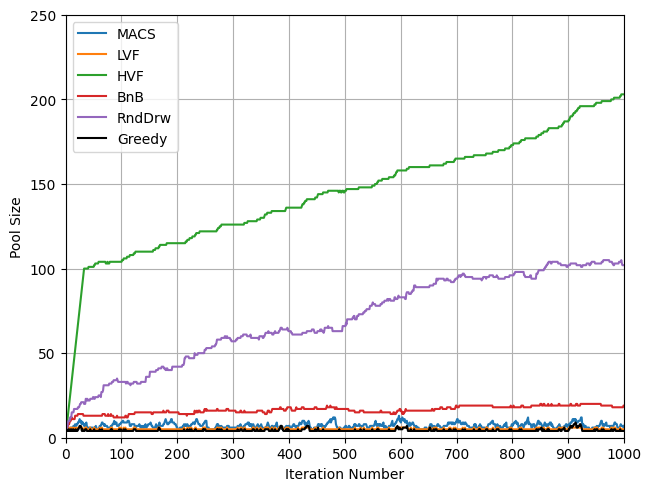

In [5]:
fig = plt.figure(constrained_layout=True)
#fig.suptitle('Pool Size')
plt.plot(poolsize, label='MACS')
plt.plot(poolsize2, label='LVF')
plt.plot(poolsize3, label='HVF')
plt.plot(poolsize4, label='BnB')
plt.plot(poolsize5, label='RndDrw')
plt.plot(poolsize6, label='Greedy',color='black')
plt.xlim(1,1000)
plt.ylim(0,250)
plt.xticks(np.arange(0,1001,100))
plt.legend()
plt.grid()
plt.ylabel('Pool Size')
plt.xlabel('Iteration Number')
plt.show()

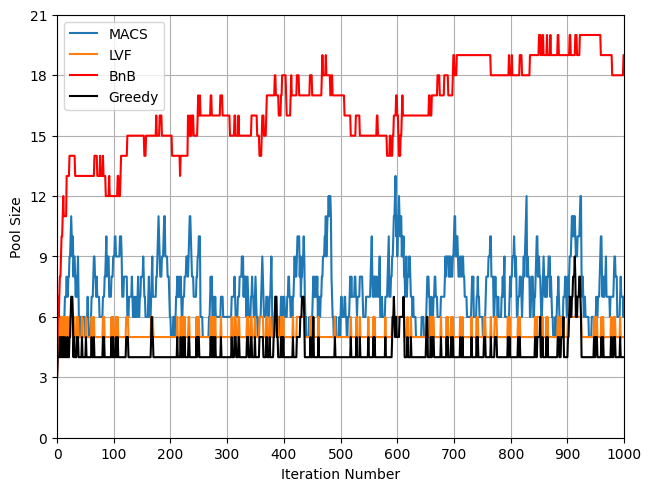

In [6]:
fig = plt.figure(constrained_layout=True)
#fig.suptitle('Pool Size')
plt.plot(poolsize, label='MACS')
plt.plot(poolsize2, label='LVF')
#plt.plot(poolsize3, label='HVF')
plt.plot(poolsize4, label='BnB', color='red')
plt.plot(poolsize6, label='Greedy',color='black')
plt.xlim(1,1000)
plt.ylim(0,21)
plt.yticks(np.arange(0,22,3))
plt.xticks(np.arange(0,1001,100))
plt.legend()
plt.grid()
plt.ylabel('Pool Size')
plt.xlabel('Iteration Number')
plt.show()

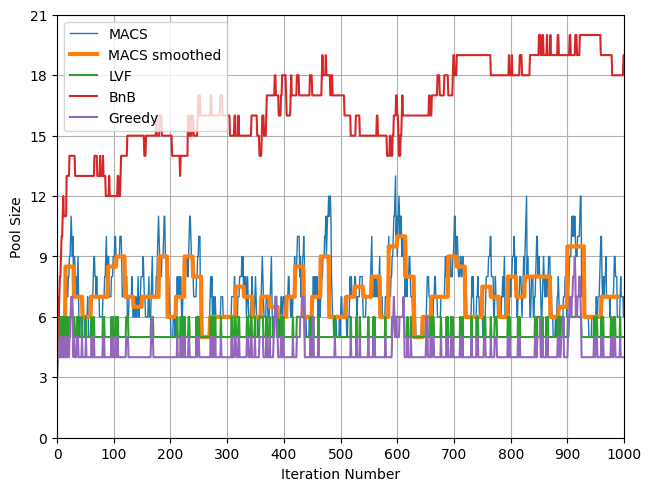

In [7]:
import statistics

frame = 15
meds = []

for k in range(0,len(poolsize)//frame):
  med = statistics.median(poolsize[k*frame:(k+1)*frame-1])
  for j in range(frame):
    meds.append(med)

fig = plt.figure(constrained_layout=True)
#fig.suptitle('Pool Size')
plt.plot(poolsize, label='MACS', linewidth=1)
plt.plot(meds, label='MACS smoothed', linewidth=3.0)
plt.plot(poolsize2, label='LVF')
#plt.plot(poolsize3, label='HVF')
plt.plot(poolsize4, label='BnB')
plt.plot(poolsize6, label='Greedy')
plt.xlim(1,1000)
plt.ylim(0,21)
plt.yticks(np.arange(0,22,3))
plt.xticks(np.arange(0,1001,100))
plt.legend()
plt.grid()
plt.ylabel('Pool Size')
plt.xlabel('Iteration Number')
plt.show()

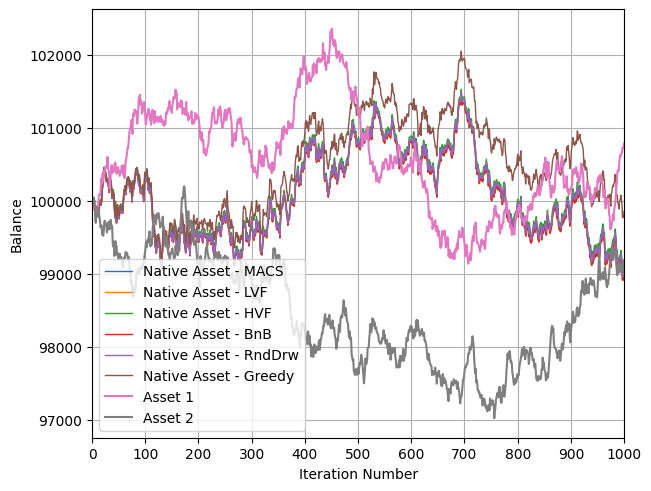

In [8]:
fig1 = plt.figure(constrained_layout=True)
#fig1.suptitle('Balance')
d = [d[f'v_{0}'] for d in balance]
d2 = [d2[f'v_{0}'] for d2 in balance2]
d3 = [d3[f'v_{0}'] for d3 in balance3]
d4 = [d4[f'v_{0}'] for d4 in balance4]
d5 = [d5[f'v_{0}'] for d5 in balance5]
d6 = [d6[f'v_{0}'] for d6 in balance6]
plt.plot(d, label='Native Asset - MACS', linewidth=1)
plt.plot(d2, label='Native Asset - LVF', linewidth=1)
plt.plot(d3, label='Native Asset - HVF', linewidth=1)
plt.plot(d4, label='Native Asset - BnB', linewidth=1)
plt.plot(d5, label='Native Asset - RndDrw', linewidth=1)
plt.plot(d6, label='Native Asset - Greedy', linewidth=1)
for j in range(1,j_max):
    d = [d[f'v_{j}'] for d in balance]
    #if j==0:
    #  plt.plot(d, label=f'Native Asset')
    #else:
    plt.plot(d, label=f'Asset {j}')

plt.legend()
plt.ylabel('Balance')
plt.xlabel('Iteration Number')
plt.xlim(1,1000)
plt.xticks(np.arange(0,1001,100))
plt.grid()

plt.show()

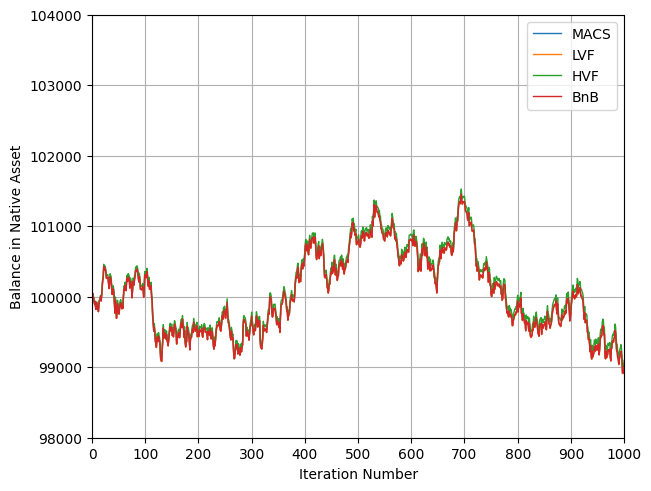

In [9]:
fig11 = plt.figure(constrained_layout=True)
#fig11.suptitle('Balance in Native Asset')
d = [d[f'v_{0}'] for d in balance]
d2 = [d2[f'v_{0}'] for d2 in balance2]
d3 = [d3[f'v_{0}'] for d3 in balance3]
d4 = [d4[f'v_{0}'] for d4 in balance4]
plt.plot(d, label='MACS', linewidth=1)
plt.plot(d2, label='LVF', linewidth=1)
plt.plot(d3, label='HVF', linewidth=1)
plt.plot(d4, label='BnB', linewidth=1)
plt.legend()
plt.ylabel('Balance in Native Asset')
plt.xlabel('Iteration Number')
plt.xlim(1,1000)
plt.ylim(98000,104000)
plt.xticks(np.arange(0,1001,100))
plt.grid()
plt.show()

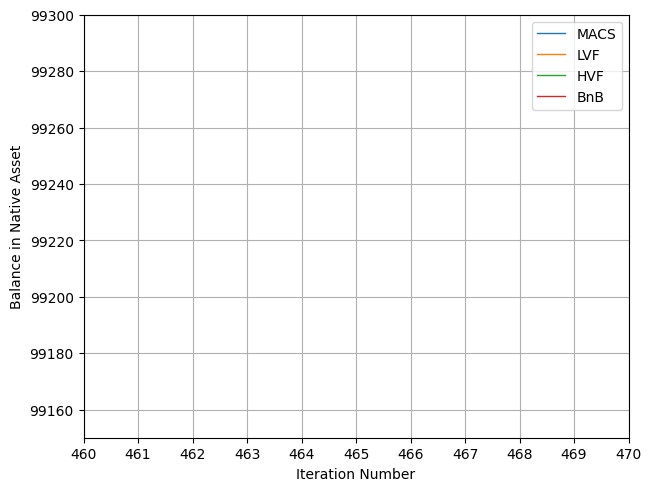

In [10]:
#Zoom in:

fig11 = plt.figure(constrained_layout=True)
#fig11.suptitle('Balance in Native Asset')
d = [d[f'v_{0}'] for d in balance]
d2 = [d2[f'v_{0}'] for d2 in balance2]
d3 = [d3[f'v_{0}'] for d3 in balance3]
d4 = [d4[f'v_{0}'] for d4 in balance4]
plt.plot(d, label='MACS', linewidth=1)
plt.plot(d2, label='LVF', linewidth=1)
plt.plot(d3, label='HVF', linewidth=1)
plt.plot(d4, label='BnB', linewidth=1)
plt.legend()
plt.ylabel('Balance in Native Asset')
plt.xlabel('Iteration Number')
plt.xlim(460,471)
plt.xticks(np.arange(460,471,1))
plt.grid()
plt.axis([460,470,99150,99300])
plt.show()

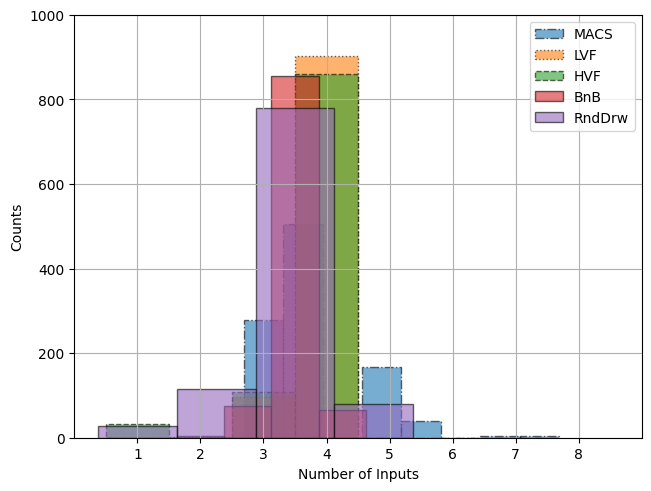

In [11]:
fig2 = plt.figure(constrained_layout=True)

plt.hist(numberOfInputs, label='MACS', bins=8, alpha = 0.6, align='left', edgecolor='black', linestyle='-.')
plt.hist(numberOfInputs2, label='LVF', bins=3, alpha = 0.6, align='left', edgecolor='black', linestyle=':')
plt.hist(numberOfInputs3, label='HVF', bins=4, alpha = 0.6, align='left', edgecolor='black', linestyle='--')
plt.hist(numberOfInputs4, label='BnB', bins=4, alpha = 0.6, align='left', edgecolor='black', linestyle='-')
plt.hist(numberOfInputs5, label='RndDrw', bins=4, alpha = 0.6, align='left', edgecolor='black', linestyle='-')
plt.legend()
plt.grid()
plt.xticks(np.arange(1,9,1))
plt.xlim(0,9)
plt.ylim(0,1000)
plt.xlabel('Number of Inputs')
plt.ylabel('Counts')

#min_ylim, max_ylim = plt.ylim()

#textstr = '\n'.join((
#    r'Mean:',
#    r'$MACS=%.3f$' % (np.mean(numberOfInputs), ),
#    r'$LVF=%.3f$' % (np.mean(numberOfInputs2), ),
#    r'$HVF=%.3f$' % (np.mean(numberOfInputs3), ),
#    r'$BnB=%.3f$' % (np.mean(numberOfInputs4), )))
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#plt.text(0.5, 900, textstr, fontsize=12,
#        verticalalignment='top', bbox=props)


plt.show()

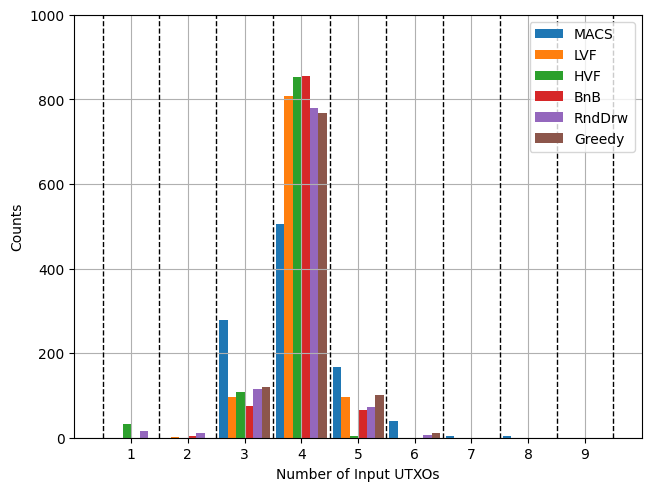

In [12]:
fig22 = plt.figure(constrained_layout=True)



from collections import Counter

items1, counts1 = zip(*sorted(Counter(numberOfInputs).items()))
items2, counts2 = zip(*sorted(Counter(numberOfInputs2).items()))
items3, counts3 = zip(*sorted(Counter(numberOfInputs3).items()))
items4, counts4 = zip(*sorted(Counter(numberOfInputs4).items()))
items5, counts5 = zip(*sorted(Counter(numberOfInputs5).items()))
items6, counts6 = zip(*sorted(Counter(numberOfInputs6).items()))


import matplotlib.pyplot as plt
import matplotlib.transforms

plt.plot(items1+items2+items3+items4, [5]*len(items1+items2+items3+items4), visible=False)

trans1 = matplotlib.transforms.Affine2D().translate(-0.375,0)
trans2 = matplotlib.transforms.Affine2D().translate(-0.225,0)
trans3 = matplotlib.transforms.Affine2D().translate(-0.075,0)
trans4 = matplotlib.transforms.Affine2D().translate(+0.075,0)
trans5 = matplotlib.transforms.Affine2D().translate(+0.225,0)
trans6 = matplotlib.transforms.Affine2D().translate(+0.375,0)


plt.bar(items1, counts1, label="MACS", width=0.15, transform=trans1+plt.gca().transData)
plt.bar(items2, counts2, label="LVF", width=0.15, transform=trans2+plt.gca().transData)
plt.bar(items3, counts3, label="HVF", width=0.15, transform=trans3+plt.gca().transData)
plt.bar(items4, counts4, label="BnB", width=0.15, transform=trans4+plt.gca().transData)
plt.bar(items5, counts5, label="RndDrw", width=0.15, transform=trans5+plt.gca().transData)
plt.bar(items6, counts6, label="Greedy", width=0.15, transform=trans6+plt.gca().transData)

plt.xticks(np.arange(1,10,1))
plt.xlim(0,10)
plt.ylim(0,1000)
plt.xlabel('Number of Input UTXOs')
plt.ylabel('Counts')

for j in range(20):
  if int(0.5*j)!=0.5*j:
   plt.axvline(0.5*j, color='k', linestyle='--', linewidth=1)


plt.grid()

plt.legend()
plt.show()

In [13]:
np.mean(numberOfInputs)

3.996

In [14]:
np.mean(numberOfInputs2)

3.998

In [15]:
np.mean(numberOfInputs3)

3.8

In [16]:
np.mean(numberOfInputs4)

3.984

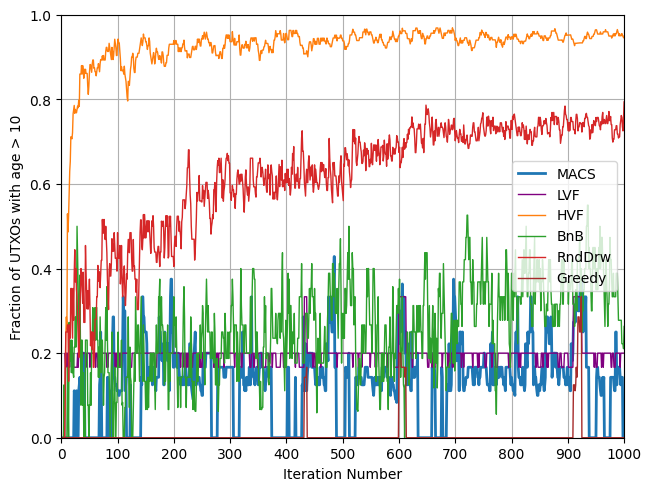

In [17]:
fig3 = plt.figure(constrained_layout=True)
#fig3.suptitle(f'Fraction of UTXOs with age > {threshold}')
plt.plot(frac_Old_Txns, label='MACS', linewidth=2)
plt.plot(frac_Old_Txns2, label='LVF', color='purple', linewidth=1)
plt.plot(frac_Old_Txns3, label='HVF', linewidth=1)
plt.plot(frac_Old_Txns4, label='BnB', linewidth=1)
plt.plot(frac_Old_Txns5, label='RndDrw', linewidth=1)
plt.plot(frac_Old_Txns6, label='Greedy', color='brown', linewidth=1)
plt.legend()
plt.ylabel(f'Fraction of UTXOs with age > {threshold}')
plt.xlabel('Iteration Number')
plt.xlim(1,1000)
plt.ylim(0,1)
plt.xticks(np.arange(0,1001,100))
plt.grid()
plt.show()

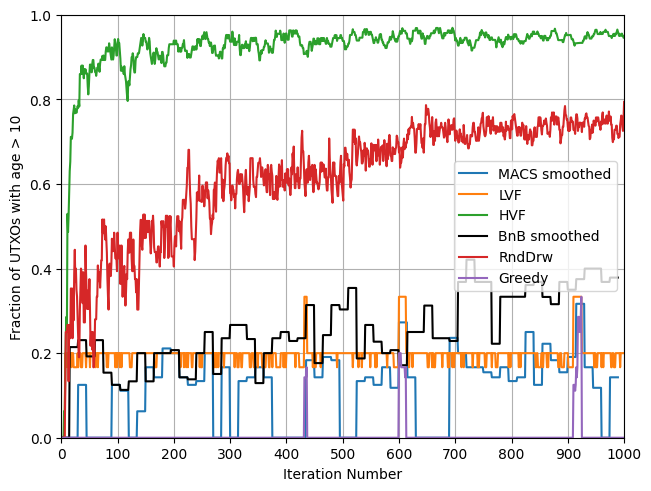

In [18]:
frac_Old_Txns
import statistics

frame = 15
meds = []
meds4 = []

for k in range(0,len(frac_Old_Txns)//frame):
  med = statistics.median(frac_Old_Txns[k*frame:(k+1)*frame-1])
  med4 = statistics.median(frac_Old_Txns4[k*frame:(k+1)*frame-1])
  for j in range(frame):
    meds.append(med)
    meds4.append(med4)
fig31 = plt.figure(constrained_layout=True)
#fig31.suptitle(f'Fraction of UTXOs with age > {threshold}')
#plt.plot(frac_Old_Txns, label='MACS')
plt.plot(meds, label='MACS smoothed', linewidth=1.5)
plt.plot(frac_Old_Txns2, label='LVF', linewidth=1.5)
plt.plot(frac_Old_Txns3, label='HVF', linewidth=1.5)
#plt.plot(frac_Old_Txns4, label='BnB')
plt.plot(meds4, label='BnB smoothed', color='black',linewidth=1.5)
plt.plot(frac_Old_Txns5, label='RndDrw', linewidth=1.5)
plt.plot(frac_Old_Txns6, label='Greedy', linewidth=1.5)
plt.legend(loc='center right')
plt.ylabel(f'Fraction of UTXOs with age > {threshold}')
plt.xlabel('Iteration Number')
plt.xlim(1,1000)
plt.ylim(0,1)
plt.xticks(np.arange(0,1001,100))
plt.grid()
plt.show()

In [19]:
utxo


[{'a': 3, 'l': 2736, 's': 30, 'v_0': 28.5, 'v_1': 976.0, 'v_2': 1824.0},
 {'a': 2, 'l': 144, 's': 30, 'v_0': 95842.5, 'v_1': 95864.0, 'v_2': 94210.0},
 {'a': 1, 'l': 114, 's': 30, 'v_0': 82.5, 'v_1': 880.0, 'v_2': 6.0},
 {'a': 0, 'l': 3, 's': 30, 'v_0': -21.5, 'v_1': 2.0, 'v_2': 84.0},
 {'v_0': 1023, 'v_1': 1059, 'v_2': 1085, 'a': 1, 'l': 1, 's': 60},
 {'v_0': 1055, 'v_1': 1034, 'v_2': 1036, 'a': 1, 'l': 1, 's': 60},
 {'v_0': 988, 'v_1': 971, 'v_2': 941, 'a': 1, 'l': 1, 's': 60}]

In [20]:
utxo2

[{'v_0': 80000, 'v_1': 0, 'v_2': 0, 'a': 1004, 'l': 0, 's': 50},
 {'a': 1, 'l': 2997, 's': 30, 'v_0': 15931.0, 'v_1': 97722.0, 'v_2': 96124.0},
 {'v_0': 1023, 'v_1': 1059, 'v_2': 1085, 'a': 1, 'l': 1, 's': 60},
 {'v_0': 1055, 'v_1': 1034, 'v_2': 1036, 'a': 1, 'l': 1, 's': 60},
 {'v_0': 988, 'v_1': 971, 'v_2': 941, 'a': 1, 'l': 1, 's': 60}]

In [21]:
utxo3

[{'a': 35, 'l': 106, 's': 30, 'v_0': 874.0, 'v_1': 999.0, 'v_2': 1073.0},
 {'a': 114, 'l': 79, 's': 30, 'v_0': 909.0, 'v_1': 948.0, 'v_2': 1072.0},
 {'a': 204, 'l': 43, 's': 30, 'v_0': 818.0, 'v_1': 967.0, 'v_2': 1059.0},
 {'a': 127, 'l': 10, 's': 30, 'v_0': 894.0, 'v_1': 886.0, 'v_2': 1059.0},
 {'a': 165, 'l': 31, 's': 30, 'v_0': 920.0, 'v_1': 885.0, 'v_2': 1057.0},
 {'a': 15, 'l': 31, 's': 30, 'v_0': 873.0, 'v_1': 930.0, 'v_2': 1052.0},
 {'a': 123, 'l': 4, 's': 30, 'v_0': 815.0, 'v_1': 889.0, 'v_2': 1047.0},
 {'a': 68, 'l': 4, 's': 30, 'v_0': 833.0, 'v_1': 911.0, 'v_2': 1040.0},
 {'a': 30, 'l': 10, 's': 30, 'v_0': 921.0, 'v_1': 987.0, 'v_2': 1034.0},
 {'a': 63, 'l': 10, 's': 30, 'v_0': 893.0, 'v_1': 874.0, 'v_2': 1034.0},
 {'a': 48, 'l': 16, 's': 30, 'v_0': 888.0, 'v_1': 1007.0, 'v_2': 1029.0},
 {'a': 193, 'l': 4, 's': 30, 'v_0': 872.0, 'v_1': 992.0, 'v_2': 1025.0},
 {'a': 23, 'l': 4, 's': 30, 'v_0': 848.0, 'v_1': 994.0, 'v_2': 1022.0},
 {'a': 252, 'l': 10, 's': 30, 'v_0': 823.0, 'v_

In [22]:
utxo4

[{'a': 167, 'l': 532, 's': 60, 'v_0': 71780.0, 'v_1': 74070.0, 'v_2': 74138.0},
 {'v_0': 1073, 'v_1': 1049, 'v_2': 984, 'a': 31, 'l': 1, 's': 60},
 {'a': 17, 'l': 1130, 's': 60, 'v_0': 6097.0, 'v_1': 11076.0, 'v_2': 466.0},
 {'a': 7, 'l': 4, 's': 60, 'v_0': 1188.0, 'v_1': 887.0, 'v_2': 1090.0},
 {'v_0': 1034, 'v_1': 1054, 'v_2': 1005, 'a': 14, 'l': 1, 's': 60},
 {'v_0': 1020, 'v_1': 1019, 'v_2': 991, 'a': 12, 'l': 1, 's': 60},
 {'a': 5, 'l': 1260, 's': 60, 'v_0': 6455.5, 'v_1': 51.0, 'v_2': 9239.0},
 {'a': 4, 'l': 7, 's': 60, 'v_0': 967.0, 'v_1': 1385.0, 'v_2': 942.0},
 {'v_0': 940, 'v_1': 992, 'v_2': 1062, 'a': 8, 'l': 1, 's': 60},
 {'a': 3, 'l': 49, 's': 60, 'v_0': 317.0, 'v_1': 1203.0, 'v_2': 1144.0},
 {'v_0': 1079, 'v_1': 959, 'v_2': 974, 'a': 6, 'l': 1, 's': 60},
 {'v_0': 970, 'v_1': 1009, 'v_2': 945, 'a': 5, 'l': 1, 's': 60},
 {'v_0': 960, 'v_1': 945, 'v_2': 994, 'a': 6, 'l': 1, 's': 60},
 {'v_0': 980, 'v_1': 1031, 'v_2': 954, 'a': 4, 'l': 1, 's': 60},
 {'v_0': 1002, 'v_1': 958, 

In [23]:
sum([u['l'] for u in utxo])

3000

In [24]:
sum([u['l'] for u in utxo2])

3000

In [25]:
sum([u['l'] for u in utxo3])

3000

In [26]:
sum([u['l'] for u in utxo4])

3000

1.9995

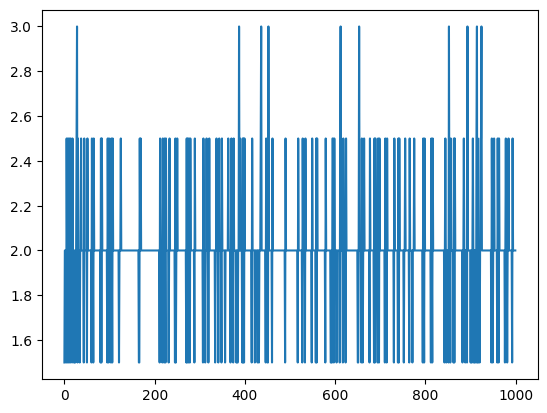

In [27]:
tr = [n*0.5 for n in numberOfInputs6]
tr
plt.plot(tr)
np.mean(tr)